**Imports**

In [2]:
import tensorflow as tf 
import tensorflow_datasets as tfds # For dataset
import numpy as np # For data manipulation
from sklearn.metrics import confusion_matrix, classification_report # For evaluation
import matplotlib.pyplot as plt # For ploting

2025-10-15 13:46:13.084735: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760535973.289727      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760535973.343232      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


**Testing Memory Growth (GPU)**

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

**Load Dataset**

In [3]:
(data, info) = tfds.load('cats_vs_dogs', with_info=True, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

I0000 00:00:1760536478.315293      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.Z1XOCK_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


**Visualize Some Images**

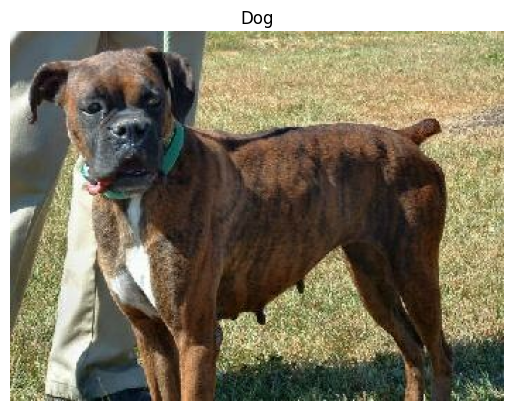

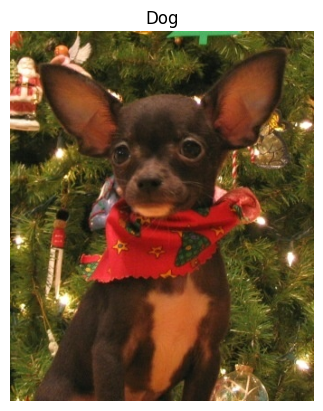

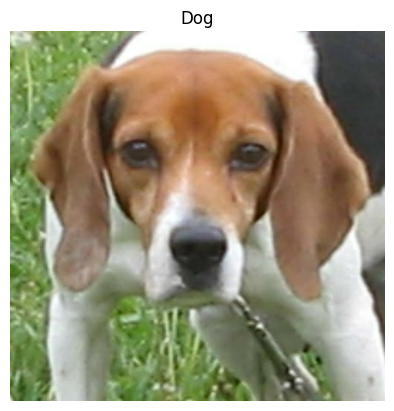

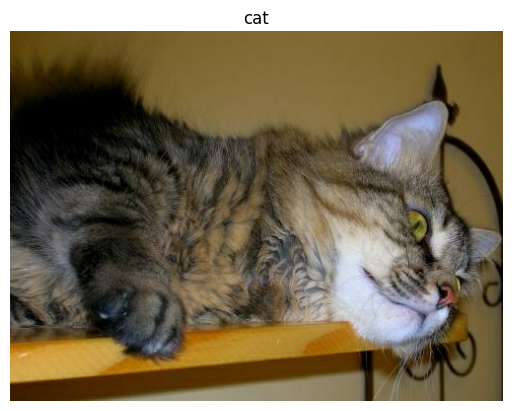

In [4]:
for image, label in data['train'].take(4):
    plt.figure()
    plt.imshow(image)
    plt.title("cat" if label.numpy() == 0 else "Dog")
    plt.axis("off")
    plt.show()

**Split Data**

In [12]:
ds_train_full = data['train']
total_count = info.splits['train'].num_examples

train_size = int(0.8 * total_count)
val_size = int(0.1 * total_count)
test_size = total_count - train_size - val_size

train = ds_train_full.take(train_size)
test_val = ds_train_full.skip(train_size)
val = test_val.take(val_size)
test = test_val.skip(val_size)

**Preprocessing**

In [15]:
IMG_SIZE = 224
BATCH_SIZE = 32

def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

**Data loader**

In [16]:

train = train.map(preprocess).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val = val.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test = test.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

**Model Initalzation**

In [17]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


**Adding Classification Head**

In [22]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(2, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

**Train Model**

In [24]:
history = model.fit(train,
                    validation_data=val,
                    epochs=10)

Epoch 1/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 32s 54ms/step - accuracy: 0.9818 - loss: 0.0511 - val_accuracy: 0.9798 - val_loss: 0.0490
Epoch 2/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 26s 43ms/step - accuracy: 0.9851 - loss: 0.0422 - val_accuracy: 0.9828 - val_loss: 0.0461
Epoch 3/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 26s 43ms/step - accuracy: 0.9855 - loss: 0.0386 - val_accuracy: 0.9811 - val_loss: 0.0469
Epoch 4/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 26s 43ms/step - accuracy: 0.9898 - loss: 0.0316 - val_accuracy: 0.9819 - val_loss: 0.0455
Epoch 5/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 25s 43ms/step - accuracy: 0.9895 - loss: 0.0283 - val_accuracy: 0.9828 - val_loss: 0.0440
Epoch 6/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 26s 43ms/step - accuracy: 0.9915 - loss: 0.0269 - val_accuracy: 0.9832 - val_loss: 0.0440
Epoch 7/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 26s 44ms/step - accuracy: 0.9933 - loss: 0.0211 - val_accuracy: 0.9824 - val_loss: 0.0418
Epoch 8/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 26s 43ms/step - accuracy: 0.9938 - loss: 0.0198 - 

**Evaluation**

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━

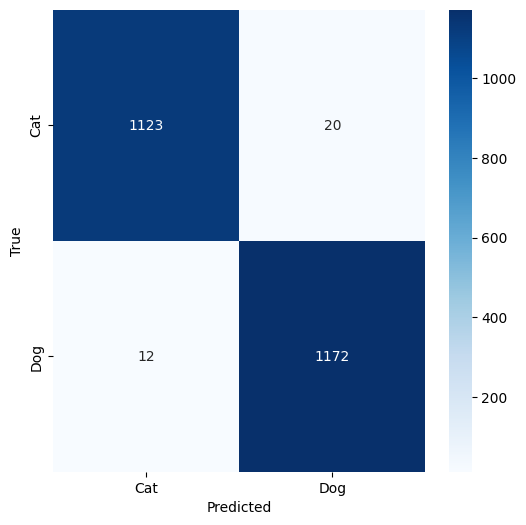

In [25]:
y_true = []
y_pred = []

for images, labels in test:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

# Classification Report
report = classification_report(y_true, y_pred, target_names=['Cat', 'Dog'])
print("Classification Report:\n", report)

# Optional: plot confusion matrix
import seaborn as sns
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

**Save and Reload Model**

In [26]:
model.save("/kaggle/working/cat_dog_model.h5")


from tensorflow.keras.models import load_model
loaded_model = load_model("/kaggle/working/cat_dog_model.h5")


In [28]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image

IMG_SIZE = 224  # same as training

def load_and_preprocess(img_path):
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # normalize
    img_array = np.expand_dims(img_array, axis=0)  # add batch dimension
    return img_array


In [ ]:
classes = ['Cat', 'Dog']

def plot_predictions(image_paths, model):
    plt.figure(figsize=(12, 6))
    
    for i, path in enumerate(image_paths):
        # Load and preprocess image
        img = image.load_img(path, target_size=(IMG_SIZE, IMG_SIZE))
        img_array = image.img_to_array(img) / 255.0
        img_array_exp = np.expand_dims(img_array, axis=0)
        
        # Predict
        pred = model.predict(img_array_exp)
        class_idx = np.argmax(pred, axis=1)[0]
        confidence = pred[0][class_idx]
        
        # Plot
        plt.subplot(1, len(image_paths), i+1)
        plt.imshow(np.array(img).astype('uint8'))  # convert PIL to NumPy array
        plt.axis('off')
        plt.title(f"{classes[class_idx]} ({confidence:.2f})")
    
    plt.show()

# Example usage
image_paths = ["path of images"]
plot_predictions(image_paths, model)
